### House Prices (Predict sales prices)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


### Import Important Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as stats
from IPython.display import display, HTML

### Basic Data Exploration

In [3]:
# Import Data
Raw_Data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
Raw_Data.sample()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
497  498          50       RL         60.0     9120   Pave  Pave      Reg   

    LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
497         Lvl    AllPub  ...        0    NaN  GdPrv         NaN       0   

    MoSold YrSold  SaleType  SaleCondition  SalePrice  
497      6   2008        WD         Normal     184000  

[1 rows x 81 columns]

In [4]:
# Function to create a scrollable table within a small window
def scrollable_table(data, table_id, title):
    html = f'<h3>{title}</h3>'
    html += f'<div id="{table_id}" style="height:200px; overflow:auto;">'
    html += data.to_html()
    html += '</div>'
    return html

In [5]:
html_data = scrollable_table(Raw_Data, 'Raw_Data', 'Show the Full training Dataset')
display(HTML(html_data))

In [6]:
Raw_Data.shape

(1460, 81)

In [7]:
# Summary statistics for numerical features
numerical_features = Raw_Data.select_dtypes(include=[np.number])
summary_stats = numerical_features.describe().T
html_numerical = scrollable_table(summary_stats, 'numerical_features', 'Summary statistics for numerical features')

display(HTML(html_numerical))

In [8]:
# Summary statistics for categorical features
categorical_features = Raw_Data.select_dtypes(include=[object])
cat_summary_stats = categorical_features.describe().T
html_categorical = scrollable_table(cat_summary_stats, 'categorical_features', 'Summary statistics for categorical features')

display(HTML(html_categorical ))

In [9]:
categorical_columns = Raw_Data.select_dtypes(include=[object]).columns.to_list()
numerical_columns = Raw_Data.columns.to_list()
for cat in categorical_columns:
    numerical_columns.remove(cat)
numerical_columns.remove('SalePrice')
target_column = 'SalePrice'

print('numerical_columns:', len(numerical_columns))
print('categorical_columns:', len(categorical_columns))

numerical_columns: 37
categorical_columns: 43


### Handle null values

In [10]:
Raw_Data.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)
ntrain = Raw_Data.shape[0]
ntest = test.shape[0]
y_train = Raw_Data.SalePrice.values
all_data = pd.concat((Raw_Data, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


In [11]:
null_values = all_data.isna().sum()
html_null_values = scrollable_table(null_values.to_frame(), 'null_values', 'Null values in the dataset')
display(HTML(html_null_values))

Text(0.5, 1.0, 'Percent missing data by feature')

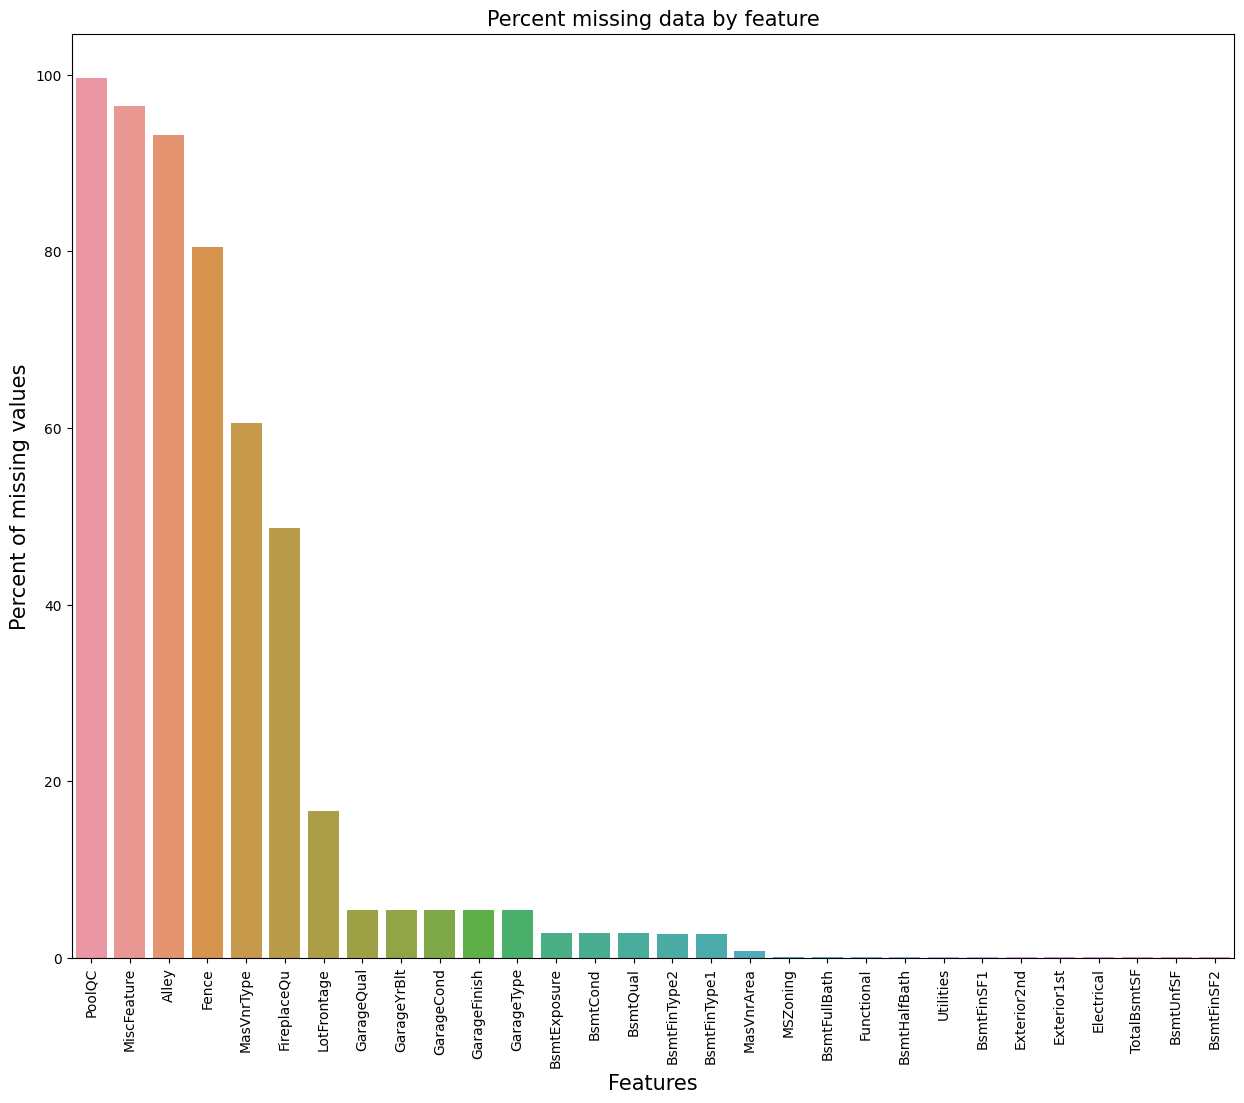

In [12]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending = False)[:30]

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation = 90)
sns.barplot(x = all_data_na.index, y = all_data_na)
plt.xlabel('Features', fontsize = 15)
plt.ylabel('Percent of missing values', fontsize = 15)
plt.title('Percent missing data by feature', fontsize = 15)

In [13]:
print(all_data['PoolQC'].isna().sum())
all_data['PoolQC'].value_counts()

2909


PoolQC
Ex    4
Gd    4
Fa    2
Name: count, dtype: int64

- **PoolQC** : data description says NA means "No  Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general. 

In [14]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")  # None --> No Pool

In [15]:
print(all_data['MiscFeature'].isna().sum())
all_data['MiscFeature'].value_counts()

2814


MiscFeature
Shed    95
Gar2     5
Othr     4
TenC     1
Name: count, dtype: int64

- **MiscFeature** : data description says NA means "no misc feature"


In [16]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")  # None --> no misc feature

In [17]:
print(all_data['Alley'].isna().sum())
all_data['Alley'].value_counts()

2721


Alley
Grvl    120
Pave     78
Name: count, dtype: int64

- **Alley** : data description says NA means "no alley access"

In [18]:
all_data["Alley"] = all_data["Alley"].fillna("None") # None --> no alley access

In [19]:
print(all_data['Fence'].isna().sum())
all_data['Fence'].value_counts()

2348


Fence
MnPrv    329
GdPrv    118
GdWo     112
MnWw      12
Name: count, dtype: int64

- **Fence** : data description says NA means "no fence"

In [20]:
all_data["Fence"] = all_data["Fence"].fillna("None") # None --> no fence

In [21]:
print(all_data['FireplaceQu'].isna().sum())
all_data['FireplaceQu'].value_counts()

1420


FireplaceQu
Gd    744
TA    592
Fa     74
Po     46
Ex     43
Name: count, dtype: int64

- **FireplaceQu** : data description says NA means "no fireplace"

In [22]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None") # None --> no fireplace

In [23]:
print(all_data['LotFrontage'].isna().sum())
all_data['LotFrontage'].value_counts()

486


LotFrontage
60.0     276
80.0     137
70.0     133
50.0     117
75.0     105
        ... 
138.0      1
152.0      1
153.0      1
135.0      1
136.0      1
Name: count, Length: 128, dtype: int64

- **LotFrontage** : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can **fill in missing values by the median LotFrontage of the neighborhood**.

In [24]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data.groupby("Neighborhood")["LotFrontage"].median()

Neighborhood
Blmngtn    43.0
Blueste    24.0
BrDale     21.0
BrkSide    51.0
ClearCr    80.5
CollgCr    70.0
Crawfor    70.0
Edwards    65.0
Gilbert    64.0
IDOTRR     60.0
MeadowV    21.0
Mitchel    74.0
NAmes      73.0
NPkVill    24.0
NWAmes     80.0
NoRidge    89.0
NridgHt    92.0
OldTown    60.0
SWISU      60.0
Sawyer     72.0
SawyerW    67.0
Somerst    72.5
StoneBr    60.0
Timber     82.0
Veenker    80.0
Name: LotFrontage, dtype: float64

In [25]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [26]:
print(all_data['GarageType'].value_counts())
print(all_data['GarageFinish'].value_counts())
print(all_data['GarageQual'].value_counts())
print(all_data['GarageCond'].value_counts())

GarageType
Attchd     1723
Detchd      779
BuiltIn     186
Basment      36
2Types       23
CarPort      15
Name: count, dtype: int64
GarageFinish
Unf    1230
RFn     811
Fin     719
Name: count, dtype: int64
GarageQual
TA    2604
Fa     124
Gd      24
Po       5
Ex       3
Name: count, dtype: int64
GarageCond
TA    2654
Fa      74
Gd      15
Po      14
Ex       3
Name: count, dtype: int64


- **GarageType, GarageFinish, GarageQual and GarageCond** : Replacing missing data with None

In [27]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

In [28]:
print(all_data['GarageYrBlt'].value_counts())
print(all_data['GarageArea'].value_counts())
print(all_data['GarageCars'].value_counts())

GarageYrBlt
2005.0    142
2006.0    115
2007.0    115
2004.0     99
2003.0     92
         ... 
1896.0      1
1895.0      1
2207.0      1
1943.0      1
1919.0      1
Name: count, Length: 103, dtype: int64
GarageArea
0.0       157
576.0      97
440.0      96
240.0      69
484.0      68
         ... 
859.0       1
744.0       1
1105.0      1
293.0       1
1200.0      1
Name: count, Length: 603, dtype: int64
GarageCars
2.0    1594
1.0     776
3.0     374
0.0     157
4.0      16
5.0       1
Name: count, dtype: int64


- **GarageYrBlt, GarageArea and GarageCars** : Replacing missing data with 0 (Since No garage = no cars in such garage.)


In [29]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

- **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath** : missing values are likely zero for having no basement

In [30]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : For all these categorical basement-related features, NaN means that there is no  basement.


In [31]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')  # None --> no basement

In [32]:
print(all_data['MasVnrArea'].value_counts())
print(all_data['MasVnrType'].value_counts())

MasVnrArea
0.0       1738
120.0       15
176.0       13
200.0       13
216.0       12
          ... 
167.0        1
1115.0       1
576.0        1
443.0        1
251.0        1
Name: count, Length: 444, dtype: int64
MasVnrType
BrkFace    879
Stone      249
BrkCmn      25
Name: count, dtype: int64


- **MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type. 


In [33]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [34]:
print(all_data['MSZoning'].isna().sum())
print(all_data['MSZoning'].value_counts())

4
MSZoning
RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: count, dtype: int64


- **MSZoning (The general zoning classification)** :  'RL' is by far  the most common value.  So we can fill in missing values with 'RL'


In [35]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [36]:
print(all_data['Utilities'].isna().sum())
print(all_data['Utilities'].value_counts())

2
Utilities
AllPub    2916
NoSeWa       1
Name: count, dtype: int64


- **Utilities** : For this categorical feature all records are "AllPub", except for one "NoSeWa"  and 2 NA . Since the house with 'NoSewa' is in the training set, **this feature won't help in predictive modelling**. We can then safely  remove it.


In [37]:
all_data = all_data.drop(['Utilities'], axis=1)

In [38]:
print(all_data['Functional'].isna().sum())
print(all_data['Functional'].value_counts())

2
Functional
Typ     2717
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: count, dtype: int64


- **Functional** : data description says NA means typical

In [39]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")  # Typ --> typical --> NA

In [40]:
print(all_data['Electrical'].isna().sum())
print(all_data['Electrical'].value_counts())

1
Electrical
SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: count, dtype: int64


- **Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.


In [41]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [42]:
print(all_data['KitchenQual'].isna().sum())
print(all_data['KitchenQual'].value_counts())

1
KitchenQual
TA    1492
Gd    1151
Ex     205
Fa      70
Name: count, dtype: int64


- **KitchenQual**: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent)  for the missing value in KitchenQual.


In [43]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

In [44]:
print(all_data['Exterior1st'].value_counts())
print(all_data['Exterior2nd'].value_counts())

Exterior1st
VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
AsphShn       2
Stone         2
CBlock        2
ImStucc       1
Name: count, dtype: int64
Exterior2nd
VinylSd    1014
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     126
Wd Shng      81
BrkFace      47
Stucco       47
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: count, dtype: int64


- **Exterior1st and Exterior2nd** : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string


In [45]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

In [46]:
print(all_data['SaleType'].isna().sum())
print(all_data['SaleType'].value_counts())

1
SaleType
WD       2525
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: count, dtype: int64


- **SaleType** : Fill in again with most frequent which is "WD"

In [47]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [48]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

Empty DataFrame
Columns: [Missing Ratio]
Index: []

In [49]:
all_data.isna().sum().sum()

0

In [50]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [51]:
train.shape

(1460, 78)

### Exploratory data analysis

#### Data Correlation

<Axes: >

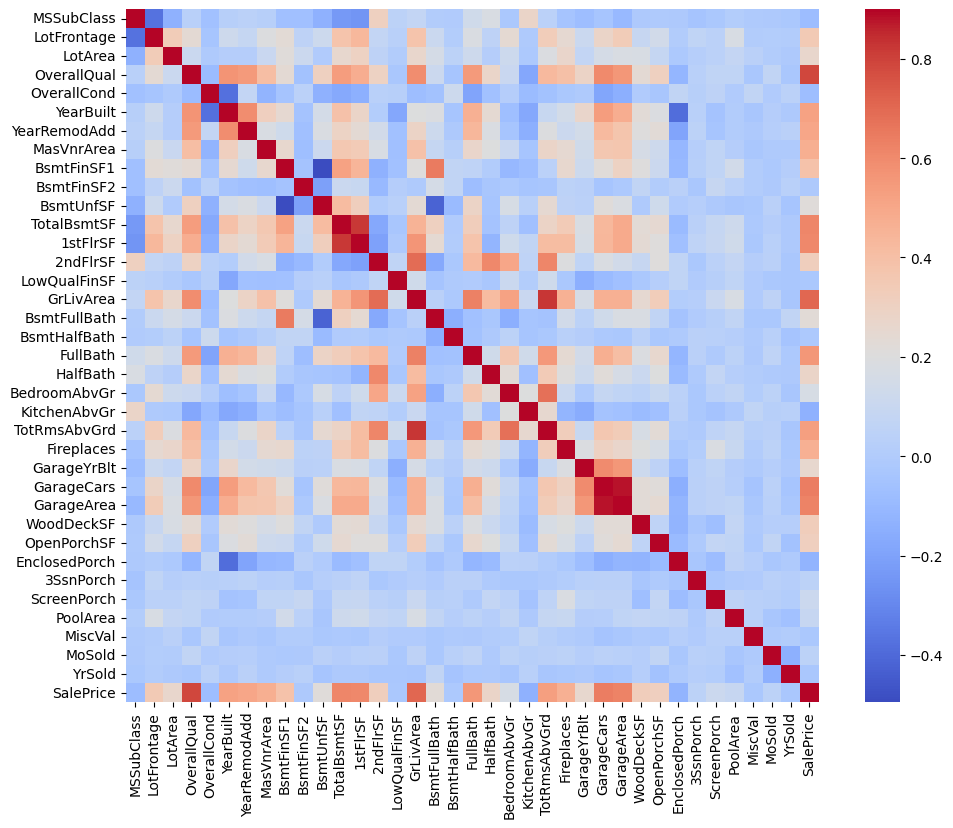

In [52]:
#Correlation map to see how features are correlated with SalePrice
numerical_columns.remove('Id')
numerical_columns.append('SalePrice')
train['SalePrice'] = y_train
corrmat = train[numerical_columns].corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True, cmap='coolwarm')

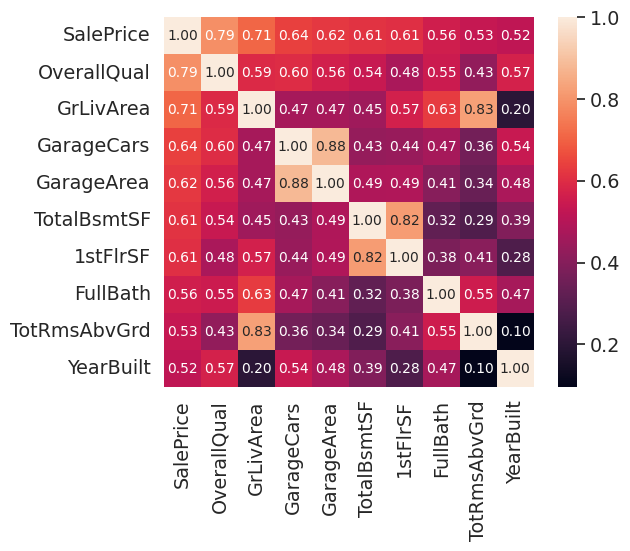

In [53]:
#saleprice correlation matrix
k = 10        #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale = 1.25)
hm = sns.heatmap(cm, cbar = True, annot = True, square = True, fmt = '.2f', annot_kws = {'size': 10}, yticklabels = cols.values,
                 xticklabels = cols.values)
plt.show()

#### Scatter plots between 'SalePrice' and correlated variables

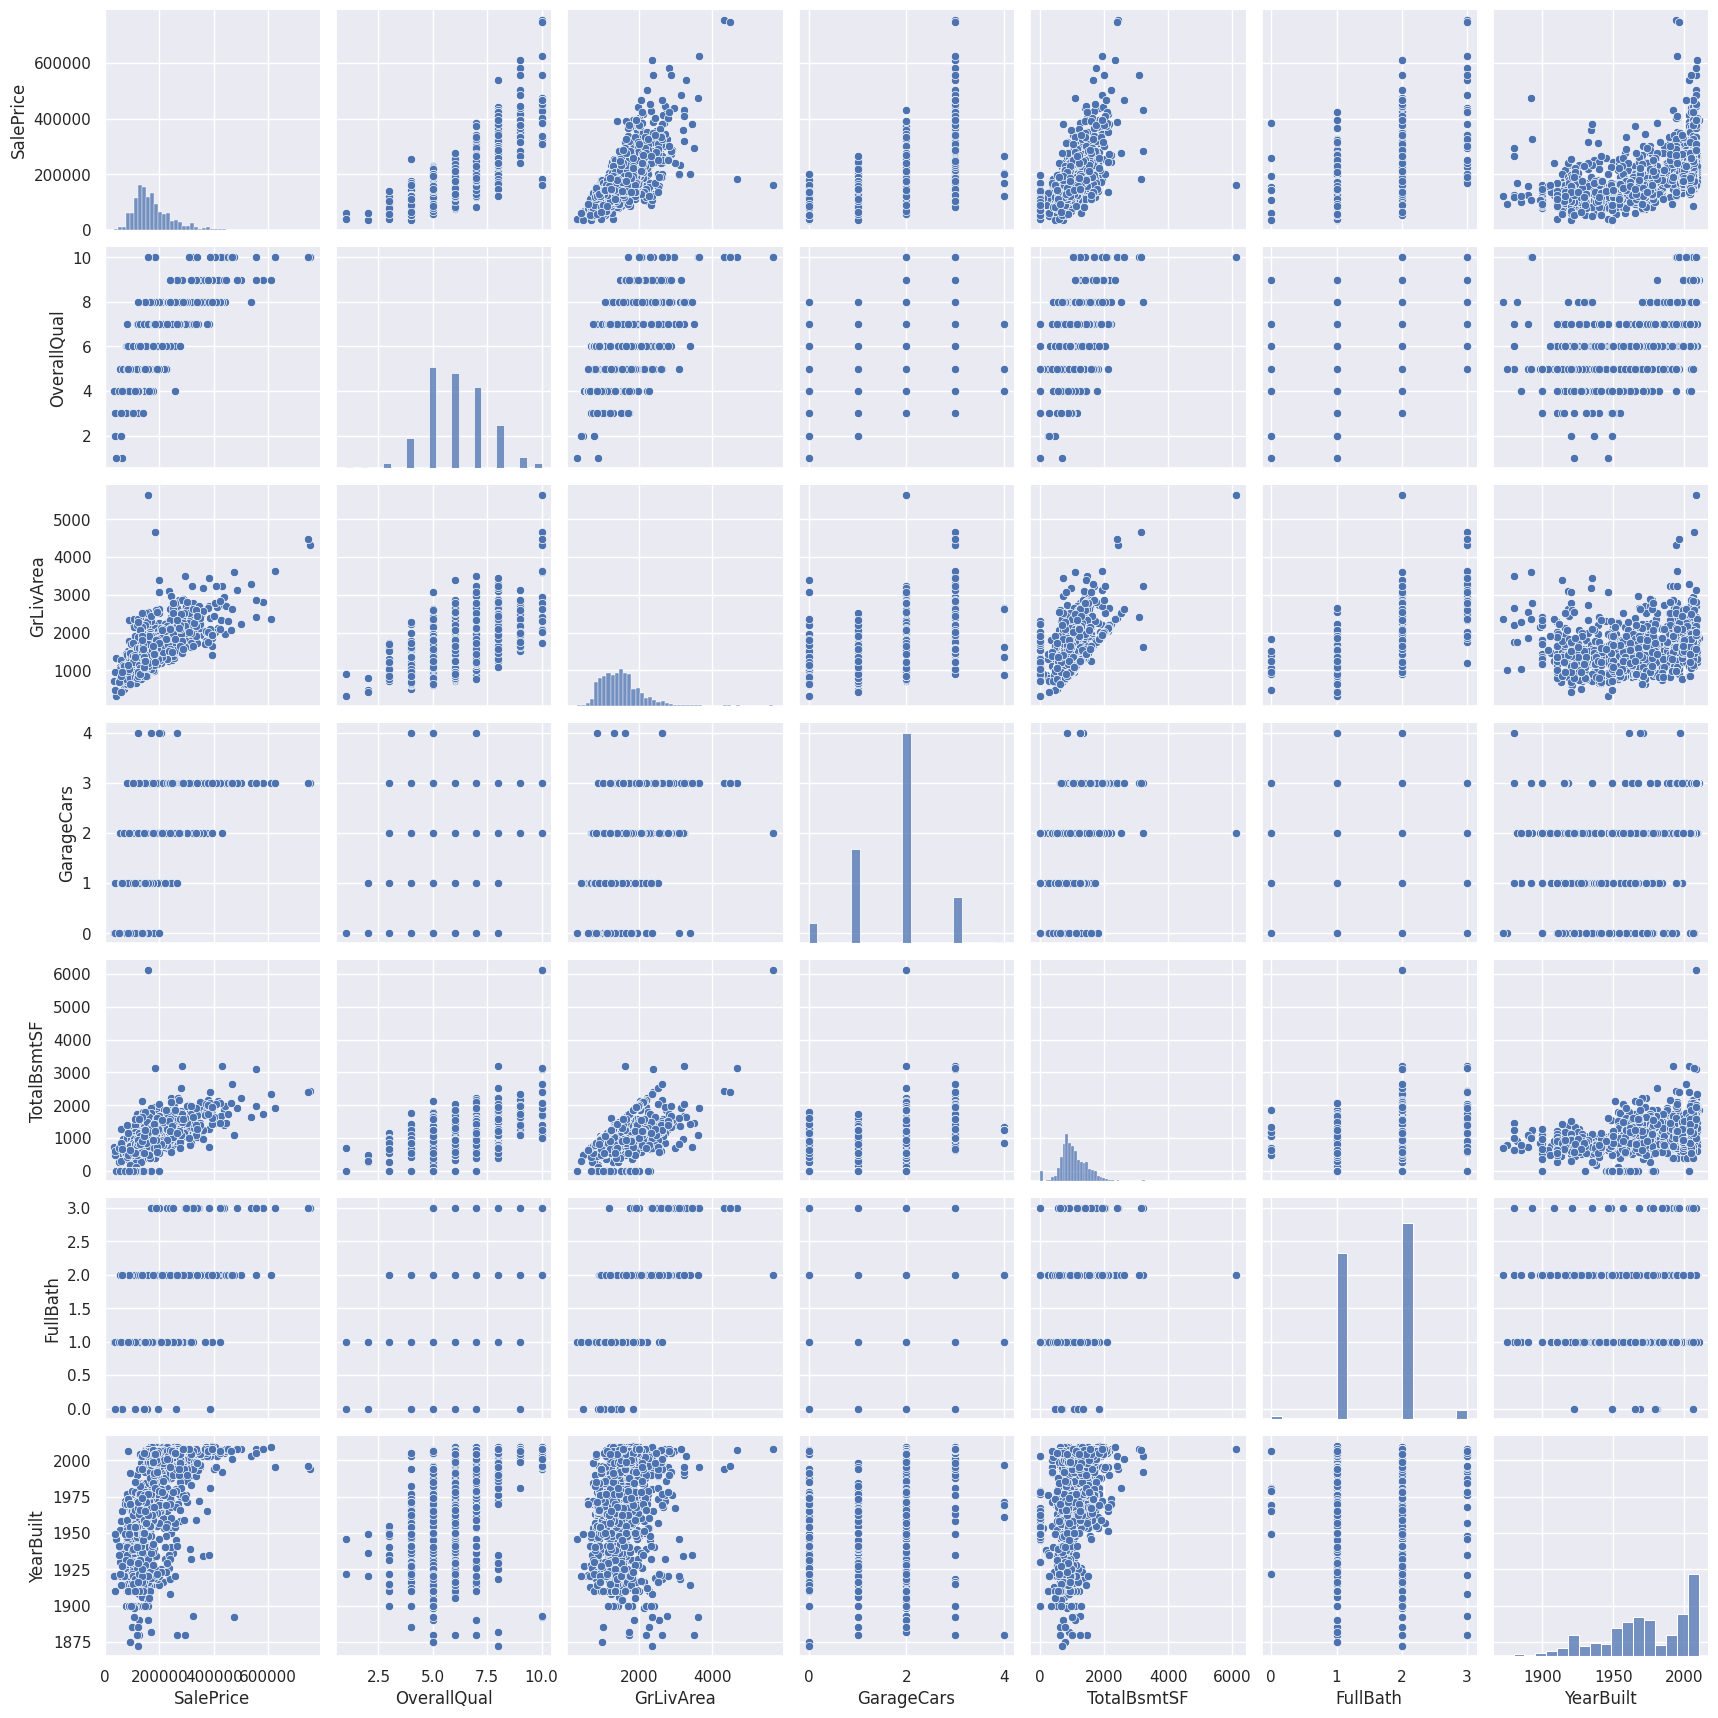

In [54]:
#scatterplot
%matplotlib inline
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

#### Now let us plot the distribution for all the numerical features.

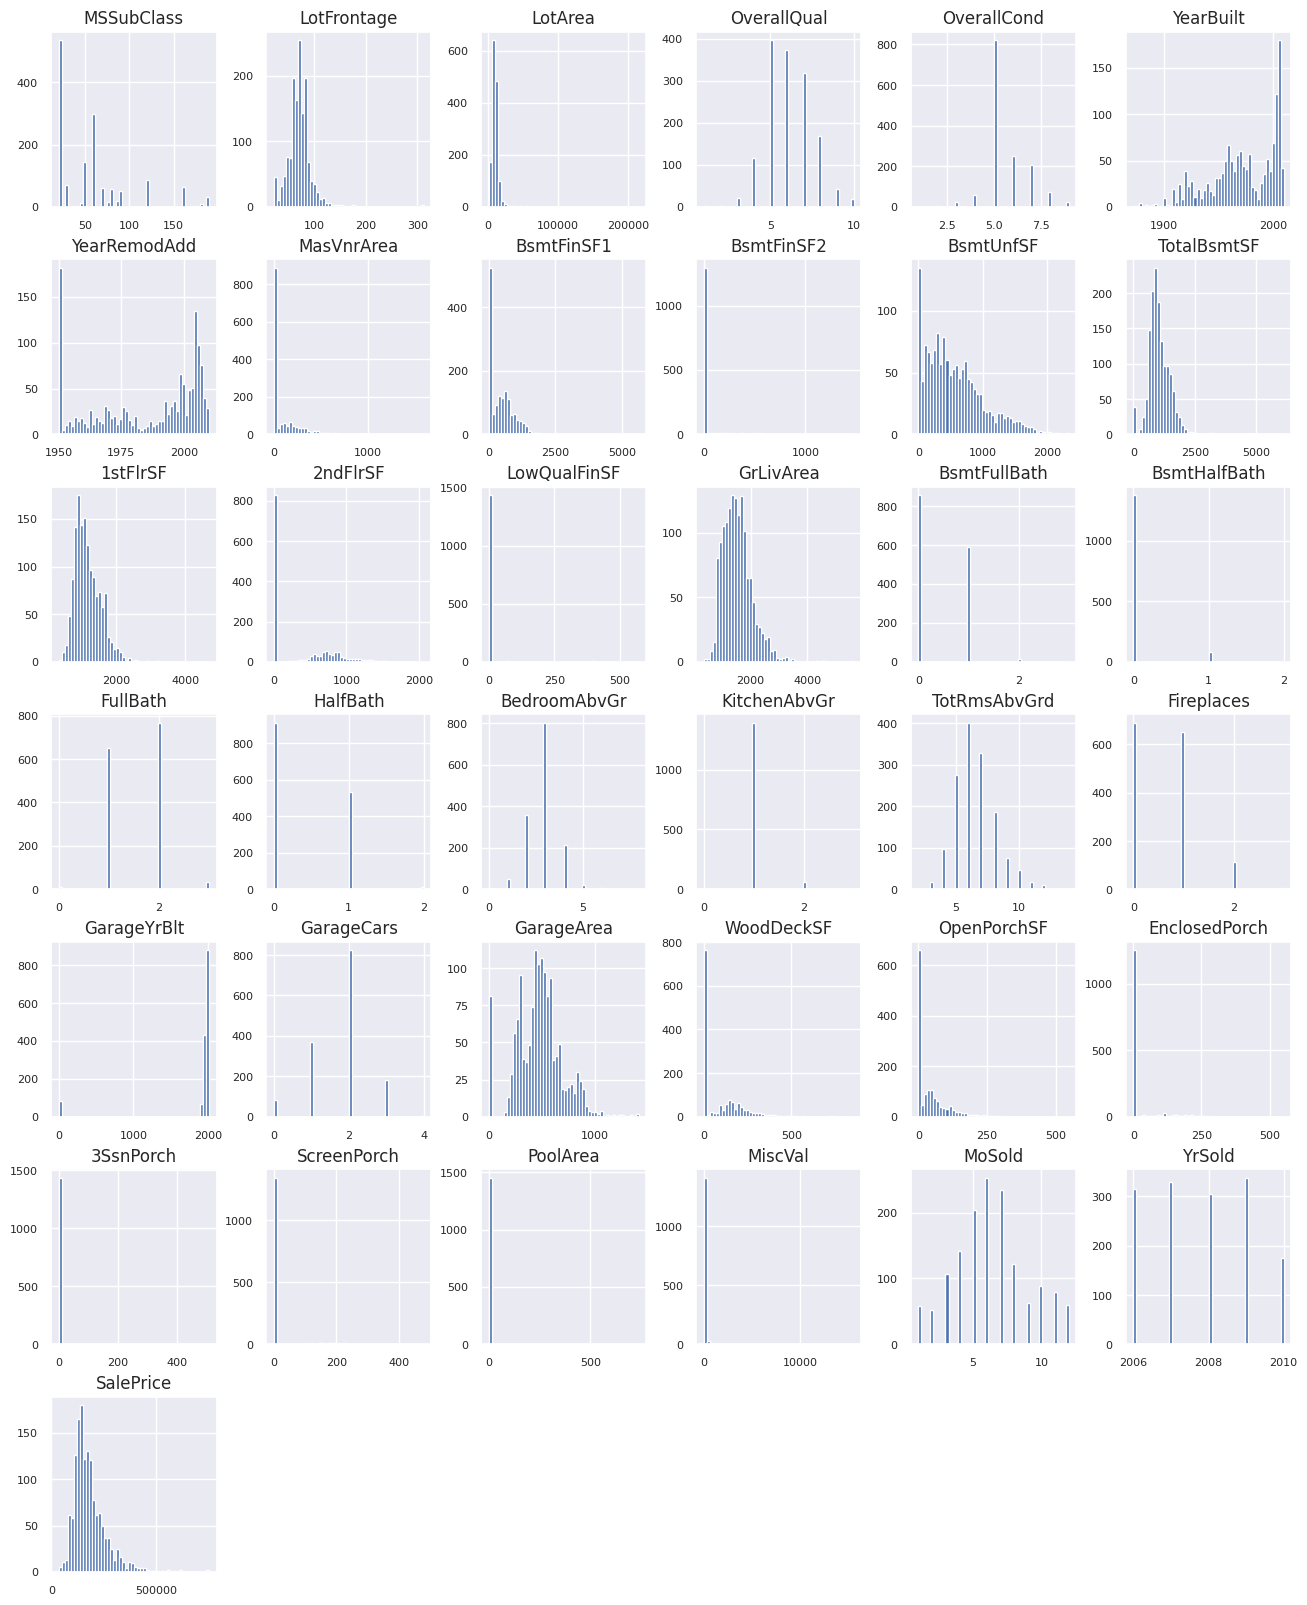

In [55]:
train[numerical_columns].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

#### Explore the dependent variable

In [56]:
# Fit a normal distribution to the SalePrice data
mu, sigma = stats.norm.fit(train['SalePrice'])

# Create a histogram of the SalePrice column
hist_data = go.Histogram(x=train['SalePrice'], nbinsx=50, name="Histogram", opacity=0.75, histnorm='probability density', marker=dict(color='purple'))

# Calculate the normal distribution based on the fitted parameters
x_norm = np.linspace(train['SalePrice'].min(), train['SalePrice'].max(), 100)
y_norm = stats.norm.pdf(x_norm, mu, sigma)

# Create the normal distribution overlay
norm_data = go.Scatter(x = x_norm, y = y_norm, mode = "lines", name = f"Normal dist. (μ = {mu:.2f}, σ = {sigma:.2f})",
                       line = dict(color = "green"))

# Combine the histogram and the overlay
fig = go.Figure(data = [hist_data, norm_data])

# Set the layout for the plot
fig.update_layout(
    title = "SalePrice Distribution",
    xaxis_title = "SalePrice",
    yaxis_title = "Density",
    legend_title_text = "Fitted Normal Distribution",
    plot_bgcolor = 'rgba(32, 32, 32, 1)',
    paper_bgcolor = 'rgba(32, 32, 32, 1)',
    font=dict(color = 'white')
)

# Create a Q-Q plot
qq_data = stats.probplot(train['SalePrice'], dist = "norm")
qq_fig = px.scatter(x = qq_data[0][0], y = qq_data[0][1], labels = {'x': 'Theoretical Quantiles', 'y': 'Ordered Values'},
                    color_discrete_sequence = ["purple"])
qq_fig.update_layout(
    title = "Q-Q plot",
    plot_bgcolor = 'rgba(32, 32, 32, 1)',
    paper_bgcolor = 'rgba(32, 32, 32, 1)',
    font=dict(color = 'white')
)

# Calculate the line of best fit
slope, intercept, r_value, p_value, std_err = stats.linregress(qq_data[0][0], qq_data[0][1])
line_x = np.array(qq_data[0][0])
line_y = intercept + slope * line_x

# Add the line of best fit to the Q-Q plot
line_data = go.Scatter(x = line_x, y = line_y, mode = "lines", name = "Normal Line", line = dict(color = "green"))

# Update the Q-Q plot with the normal line
qq_fig.add_trace(line_data)

# Show the plots
fig.show()
qq_fig.show()

'SalePrice' is not normal. It shows 'peakedness', positive skewness and does not follow the diagonal line.

But everything's not lost. A simple data transformation can solve the problem. This is one of the awesome things you can learn in statistical books: in case of positive skewness, log transformations usually works well. When I discovered this, I felt like an Hogwarts' student discovering a new cool spell.

In [57]:
#applying log transformation
train['SalePrice'] = np.log(train['SalePrice'])

In [58]:
#transformed histogram and normal probability plot

# Fit a normal distribution to the SalePrice data
mu, sigma = stats.norm.fit(train['SalePrice'])

# Create a histogram of the SalePrice column
hist_data = go.Histogram(x=train['SalePrice'], nbinsx=50, name="Histogram", opacity=0.75, histnorm='probability density', marker=dict(color='purple'))

# Calculate the normal distribution based on the fitted parameters
x_norm = np.linspace(train['SalePrice'].min(), train['SalePrice'].max(), 100)
y_norm = stats.norm.pdf(x_norm, mu, sigma)

# Create the normal distribution overlay
norm_data = go.Scatter(x = x_norm, y = y_norm, mode = "lines", name = f"Normal dist. (μ = {mu:.2f}, σ = {sigma:.2f})",
                       line = dict(color = "green"))

# Combine the histogram and the overlay
fig = go.Figure(data = [hist_data, norm_data])

# Set the layout for the plot
fig.update_layout(
    title = "SalePrice Distribution",
    xaxis_title = "SalePrice",
    yaxis_title = "Density",
    legend_title_text = "Fitted Normal Distribution",
    plot_bgcolor = 'rgba(32, 32, 32, 1)',
    paper_bgcolor = 'rgba(32, 32, 32, 1)',
    font=dict(color = 'white')
)

# Create a Q-Q plot
qq_data = stats.probplot(train['SalePrice'], dist = "norm")
qq_fig = px.scatter(x = qq_data[0][0], y = qq_data[0][1], labels = {'x': 'Theoretical Quantiles', 'y': 'Ordered Values'},
                    color_discrete_sequence = ["purple"])
qq_fig.update_layout(
    title = "Q-Q plot",
    plot_bgcolor = 'rgba(32, 32, 32, 1)',
    paper_bgcolor = 'rgba(32, 32, 32, 1)',
    font=dict(color = 'white')
)

# Calculate the line of best fit
slope, intercept, r_value, p_value, std_err = stats.linregress(qq_data[0][0], qq_data[0][1])
line_x = np.array(qq_data[0][0])
line_y = intercept + slope * line_x

# Add the line of best fit to the Q-Q plot
line_data = go.Scatter(x = line_x, y = line_y, mode = "lines", name = "Normal Line", line = dict(color = "green"))

# Update the Q-Q plot with the normal line
qq_fig.add_trace(line_data)

# Show the plots
fig.show()
qq_fig.show()

#### Distribution of dwelling types and their relation to sale prices

In [59]:
train['SalePrice'] = y_train

In [60]:
dwelling_types = train['BldgType'].value_counts()
dwelling_prices = train.groupby('BldgType')['SalePrice'].mean()

# Format labels for the second graph
formatted_dwelling_prices = ['$' + f'{value:,.2f}' for value in dwelling_prices.values]

# Create bar charts
fig1 = go.Figure(data = [go.Bar(
    x = dwelling_types.index,
    y = dwelling_types.values,
    marker_color = 'rgb(76, 175, 80)',
    text = dwelling_types.values,
    textposition = 'outside',
    width = 0.4,
    marker = dict(line = dict(width = 2, color = 'rgba(0,0,0,1)'), opacity = 1)
)])
fig1.update_layout(
    title = 'Distribution of Building Types',
    xaxis_title = 'Building Type',
    yaxis_title = 'Count',
    plot_bgcolor = 'rgba(34, 34, 34, 1)',
    paper_bgcolor = 'rgba(34, 34, 34, 1)',
    font=dict(color = 'white')
)

fig2 = go.Figure(data = [go.Bar(
    x = dwelling_prices.index,
    y = dwelling_prices.values,
    marker_color = 'rgb(156, 39, 176)',
    text = formatted_dwelling_prices,
    textposition = 'outside',
    width = 0.4,
    marker = dict(line = dict(width = 2, color = 'rgba(0,0,0,1)'), opacity = 1)
)])
fig2.update_layout(
    title = 'Average Sale Price by Building Type',
    xaxis_title = 'Building Type',
    yaxis_title = 'Price',
    plot_bgcolor = 'rgba(34, 34, 34, 1)',
    paper_bgcolor = 'rgba(34, 34, 34, 1)',
    font=dict(color = 'white')
)

# Show the figures
fig1.show()
fig2.show()

#### Zoning impact on sale price


In [61]:
zoning_prices = train.groupby('MSZoning')['SalePrice'].mean()
fig3 = px.bar(x = zoning_prices.index, y = zoning_prices.values, title = 'Average Sale Price by Zoning',
              color_discrete_sequence = ['purple', 'green'], text = zoning_prices.values,
              template = 'plotly_dark')

fig3.update_traces(texttemplate = '$%{text:,.0f}', textposition = 'outside')
fig3.update_yaxes(title = 'Sale Price', tickprefix='$', tickformat = ',')
fig3.update_xaxes(title = 'Zoning')
fig3.update_layout(uniformtext_minsize = 8, uniformtext_mode = 'hide')

fig3.show()

#### Street Prices

In [62]:
street_prices = train.groupby('Street')['SalePrice'].mean()
colors_street = np.where(street_prices.index == 'Pave', 'purple', 'green')
fig5 = px.bar(x = street_prices.index, y = street_prices.values, title = 'Average Sale Price by Street Type',
              template = 'plotly_dark', text = street_prices.values,
              color = colors_street, color_discrete_sequence = ['purple', 'green'])

fig5.update_traces(texttemplate = '$%{text:,.0f}', textposition = 'outside')
fig5.update_yaxes(title = 'Sale Price', tickprefix = '$', tickformat = ',')
fig5.update_xaxes(title = 'Street Type')
fig5.update_layout(showlegend = False)

#### Alley Prices

In [63]:
alley_prices = train.groupby('Alley')['SalePrice'].mean()
colors_alley = np.where(alley_prices.index == 'Pave', 'purple', 'green')
fig6 = px.bar(x = alley_prices.index, y = alley_prices.values, title = 'Average Sale Price by Alley Type',
              template = 'plotly_dark', text = alley_prices.values,
              color = colors_alley, color_discrete_sequence = ['purple', 'green'])

fig6.update_traces(texttemplate = '$%{text:,.0f}', textposition = 'outside')
fig6.update_yaxes(title = 'Sale Price', tickprefix = '$', tickformat = ',')
fig6.update_xaxes(title = 'Alley Type')
fig6.update_layout(showlegend = False)

#### Shape Prices

In [64]:
colors = px.colors.qualitative.Plotly
shape_prices = train.groupby('LotShape')['SalePrice'].mean()
fig7 = px.bar(x = shape_prices.index, y = shape_prices.values, title = 'Average Sale Price by Property Shape',
              template = 'plotly_dark', text = shape_prices.values)

fig7.update_traces(marker_color = colors, texttemplate = '$%{text:,.0f}', textposition = 'outside')
fig7.update_yaxes(title = 'Sale Price', tickprefix = '$', tickformat = ',')
fig7.update_xaxes(title = 'Property Shape')
fig7.update_layout(showlegend=False)

#### Contour Prices

In [65]:
contour_prices = train.groupby('LandContour')['SalePrice'].mean()
fig8 = px.bar(x = contour_prices.index, y = contour_prices.values, title = 'Average Sale Price by Property Contour',
              template = 'plotly_dark', text = contour_prices.values)

fig8.update_traces(marker_color = colors, texttemplate = '$%{text:,.0f}', textposition = 'outside')
fig8.update_yaxes(title = 'Sale Price', tickprefix = '$', tickformat = ',')
fig8.update_xaxes(title = 'Property Contour')
fig8.update_layout(showlegend = False)

#### Calculate Property Age

In [66]:
data_2 = train.copy()
data_2['PropertyAge'] = data_2['YrSold'] - data_2['YearBuilt']

# Calculate Correlation between Property Age and Sale Price
age_price_corr = data_2['PropertyAge'].corr(data_2['SalePrice'])
print(f'Correlation between Property Age and Sale Price: {age_price_corr}')

# Create a scatter plot to visualize the relationship between Property Age and Sale Price
fig9 = px.scatter(data_2, x = 'PropertyAge', y = 'SalePrice', title = 'Property Age vs Sale Price', color = 'PropertyAge', color_continuous_scale = px.colors.sequential.Purp)

fig9.update_layout(plot_bgcolor = 'rgb(30,30,30)', paper_bgcolor = 'rgb(30,30,30)', font = dict(color = 'white'))

fig9.show()

Correlation between Property Age and Sale Price: -0.523350417546816


#### Calculate Correlation between Living Area and Sale Price

In [67]:
living_area_price_corr = train['GrLivArea'].corr(train['SalePrice'])
print(f'Correlation between Living Area (above grade) and Sale Price: {living_area_price_corr}')

# Create a scatter plot to visualize the relationship between Living Area and Sale Price
fig10 = px.scatter(train, x = 'GrLivArea', y = 'SalePrice', title = 'Living Area (above grade) vs Sale Price', color = 'GrLivArea',
                   color_continuous_scale = px.colors.sequential.Purp)

fig10.update_layout(plot_bgcolor = 'rgb(30,30,30)', paper_bgcolor = 'rgb(30,30,30)', font = dict(color = 'white'))

fig10.show()

Correlation between Living Area (above grade) and Sale Price: 0.7086244776126521


#### Box plot of price over the years

In [68]:
yearly_avg_sale_price = train.groupby('YrSold')['SalePrice'].mean()

fig13 = px.box(train, x = 'YrSold', y = 'SalePrice', title = 'Sale Price Trends Over the Years',
               points = False, color_discrete_sequence = ['green'])

fig13.add_trace(px.line(x = yearly_avg_sale_price.index, y = yearly_avg_sale_price.values).data[0])

fig13.update_traces(line = dict(color = 'purple', width = 4), selector = dict(type = 'scatter', mode = 'lines'))

for year, avg_price in yearly_avg_sale_price.items():
    fig13.add_annotation(
        x = year,
        y = avg_price,
        text = f"{avg_price:,.0f}",
        font = dict(color='white'),
        showarrow = False,
        bgcolor = 'rgba(128, 0, 128, 0.6)'
    )

fig13.update_layout(
    plot_bgcolor = 'rgb(30,30,30)',
    paper_bgcolor = 'rgb(30,30,30)',
    font=dict(color = 'white'),
    xaxis_title = 'Year Sold',
    yaxis_title = 'Sale Price'
)

fig13.show()

### Data Pipeline

In [69]:
train.sample()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
78          90       RL         72.0    10778   Pave  None      Reg   

   LandContour LotConfig LandSlope  ... PoolArea PoolQC Fence MiscFeature  \
78         Lvl    Inside       Gtl  ...        0   None  None        None   

   MiscVal  MoSold  YrSold  SaleType  SaleCondition SalePrice  
78       0       4    2010        WD         Normal    136500  

[1 rows x 79 columns]

In [70]:
test.sample()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
2370         160       FV         24.0     2117   Pave  None      Reg   

     LandContour LotConfig LandSlope  ... ScreenPorch PoolArea PoolQC Fence  \
2370         Lvl    Inside       Gtl  ...           0        0   None  None   

     MiscFeature  MiscVal  MoSold  YrSold  SaleType SaleCondition  
2370        None        0       9    2007        WD        Normal  

[1 rows x 78 columns]

In [71]:
inputs = train.drop('SalePrice', axis = 1)
target = np.log(train['SalePrice'])
inputs.shape

(1460, 78)

In [72]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define transformers for numerical and categorical columns
numerical_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps = [
    ('onehot', OneHotEncoder(handle_unknown = 'ignore', sparse = False))
])

# Update categorical and numerical columns
categorical_columns = inputs.select_dtypes(include = ['object', 'category']).columns
numerical_columns = inputs.select_dtypes(include = ['int64', 'float64']).columns

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ], remainder = 'passthrough')

# Create a pipeline with the preprocessor
pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor)])

preprocessed_inputs = pipeline.fit_transform(inputs)

In [73]:
# train_test_split data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(preprocessed_inputs, target, test_size = 0.3, random_state = 42)
x_train.shape, x_test.shape

((1022, 300), (438, 300))

### Fit and Parameter Tune models

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state = 42),
    'XGBoost': XGBRegressor(random_state = 42)
}

# Define the hyperparameter grids for each model
params_grids = {
    'LinearRegression': {},
    'RandomForest': {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 30],
        'min_samples_split': [2, 5, 10],
    },
    'XGBoost': {
        'n_estimators': [100, 200, 500],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 6, 10],
    }
}
cv = KFold(n_splits = 3, shuffle = True, random_state = 42)

# train models
grids = {}
for model_name, model in models.items():
    print(f'training and tuning {model_name}')
    grids[model_name] = GridSearchCV(model, param_grid = params_grids[model_name], cv = cv, scoring = 'neg_mean_squared_error',
                                    n_jobs = -1, verbose = 2)
    grids[model_name].fit(x_train, y_train)
    best_params = grids[model_name].best_params_
    best_score = np.sqrt(-1 * grids[model_name].best_score_)
    print(f'best parameters of {model_name}: {best_params}')
    print(f'best score of {model_name}: {best_score}')

training and tuning LinearRegression
Fitting 3 folds for each of 1 candidates, totalling 3 fits
best parameters of LinearRegression: {}
best score of LinearRegression: 3012711254.330997
training and tuning RandomForest
Fitting 3 folds for each of 27 candidates, totalling 81 fits
best parameters of RandomForest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
best score of RandomForest: 0.1529856173745621
training and tuning XGBoost
Fitting 3 folds for each of 27 candidates, totalling 81 fits
best parameters of XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
best score of XGBoost: 0.13605562491405


In [75]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(random_state = 42, max_iter = 10000, n_iter_no_change = 3, learning_rate_init = 0.001)

param_grid = {
    'hidden_layer_sizes': [(10,), (10, 10), (10, 10, 10), (25)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
}
grid_search_mlp = GridSearchCV(mlp, param_grid, scoring = 'neg_mean_squared_error', cv = 3, n_jobs = -1, verbose = 2)
print(f'training and tuning MLPRegressor')
grid_search_mlp.fit(x_train, y_train)
best_params = grid_search_mlp.best_params_
best_score = np.sqrt(-1 * grid_search_mlp.best_score_)
print('best parameters: ', best_params)
print('best score: ', best_score)

training and tuning MLPRegressor
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=500; total time=  11.1s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   3.8s
[CV] END max_depth=None, min_samples_split=5, n_estimators=500; total time=   9.1s
[CV] END max_depth=None, min_samples_split=10, n_estimators=500; total time=   7.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   3.7s
[CV] END max_depth=10, min_samples_split=2, n_estimators=500; total time=   9.3s
[CV] END max_depth=10, min_samples_split=5, n_estimators=500; total time=   8.6s
[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time=   2.9s
[CV] END max_depth=30, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END max_depth=30, min_samples_split=2, n_estimators=100; total time=   2.2s
[C

In [76]:
from sklearn.metrics import mean_squared_error
for i in grids.keys():
    print (i + ': ' + str(np.sqrt(mean_squared_error(grids[i].predict(x_test), y_test))))
    
print('MLPRegressor: ', str(np.sqrt(mean_squared_error(grid_search_mlp.predict(x_test), y_test))))

LinearRegression: 2784319107.250874
RandomForest: 0.13754355080352945
XGBoost: 0.12876809537393483
MLPRegressor:  0.18742178465464307


#### **Gradient Boosting Regression**

In [77]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle = True, random_state = 42).get_n_splits(x_train)
    rmse= np.sqrt(- cross_val_score(model, x_train, y_train, scoring = "neg_mean_squared_error", cv = kf))
    return(rmse)

In [78]:
from sklearn.ensemble import GradientBoostingRegressor
GBoost = GradientBoostingRegressor(n_estimators = 3000, learning_rate = 0.05,
                                   max_depth = 4, max_features = 'sqrt',
                                   min_samples_leaf = 15, min_samples_split = 10, 
                                   loss = 'huber', random_state = 5)
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} \n".format(score.mean()))

Gradient Boosting score: 0.1270 



####  **XGBoost** 

In [79]:
model_xgb = XGBRegressor(colsample_bytree = 0.4603, gamma = 0.0468, 
                             learning_rate = 0.05, max_depth = 3, 
                             min_child_weight = 1.7817, n_estimators = 2200,
                             reg_alpha = 0.4640, reg_lambda=0.8571,
                             subsample = 0.5213, silent = 1,
                             random_state = 7, nthread = -1)
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} \n".format(score.mean()))

Xgboost score: 0.1324 



#### **LightGBM**

In [80]:
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor(objective = 'regression',num_leaves = 5,
                              learning_rate = 0.05, n_estimators = 720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed = 9, bagging_seed = 9,
                              min_data_in_leaf = 6, min_sum_hessian_in_leaf = 11)
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f}\n" .format(score.mean()))

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319

#### **LASSO  Regression and Elastic Net Regression** 
- models may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's  **Robustscaler()**  method on pipeline 

In [81]:
from sklearn.preprocessing import RobustScaler

numerical_transformer = Pipeline(steps = [
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps = [
    ('onehot', OneHotEncoder(handle_unknown = 'ignore', sparse = False))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ], remainder = 'passthrough')

# Create a pipeline with the preprocessor
pipeline_robust = Pipeline(steps = [
    ('preprocessor', preprocessor)])

preprocessed_inputs = pipeline_robust.fit_transform(inputs)

x_train, x_test, y_train, y_test = train_test_split(preprocessed_inputs, target, test_size = 0.3, random_state = 42)
x_train.shape, x_test.shape

((1022, 300), (438, 300))

In [82]:
from sklearn.linear_model import ElasticNet, Lasso

lasso = Lasso(alpha =0.0005, random_state=1)
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} \n".format(score.mean()))

ENet = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} \n".format(score.mean()))


Lasso score: 0.1511 

ElasticNet score: 0.1548 



#### **Stacking averaged Models Class**

![Faron](http://i.imgur.com/QBuDOjs.jpg)
- may be described as follows:


1. Split the total training set into two disjoint sets (here **train** and .**holdout** )

2. Train several base models on the first part (**train**)

3. Test these base models on the second part (**holdout**)

4. Use the predictions from 3)  (called  out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs  to train a higher level learner called **meta-model**.

    The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training      data into 5 folds. Then we will do 5 iterations. In each iteration,  we train every base model on 4 folds and predict on   the remaining fold (holdout fold). 

    So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as new feature to train our meta-model in the step 4.

    For the prediction part , We average the predictions of  all base models on the test data  and used them as **meta-features**  on which, the final prediction is done with the meta-model.


In [83]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [84]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, lasso, model_xgb),
                                                 meta_model = GBoost)

In [85]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [86]:
stacked_averaged_models.fit(x_train, y_train.to_numpy())
stacked_train_pred = stacked_averaged_models.predict(x_train)
print(rmsle(y_train, stacked_train_pred))

0.11015476153784012


In [87]:
model_lgb.fit(x_train, y_train.to_numpy())
lgb_train_pred = model_lgb.predict(x_train)
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319

In [88]:
model_xgb.fit(x_train, y_train.to_numpy())
xgb_train_pred = model_xgb.predict(x_train)
print(rmsle(y_train, xgb_train_pred))

0.08684995443409385


In [89]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train, (stacked_train_pred * 0.70) +
               (xgb_train_pred * 0.15) + (lgb_train_pred * 0.15)))

RMSLE score on train data:
0.09596890718617333


#### **TensorFlow Decision Forests**

In [90]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

2024-05-11 13:01:52.503249: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 13:01:52.503369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 13:01:52.620612: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [91]:
def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(train)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1033 examples in training, 427 examples in testing.


**By default the Random Forest Model is configured to train classification tasks. Since this is a regression problem, we will specify the type of the task (`tfdf.keras.Task.REGRESSION`) as a parameter here.**

In [92]:
label = 'SalePrice'

'''is a high performance data loading library which is helpful when training neural networks with accelerators like GPUs and TPUs.'''
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label = label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label = label, task = tfdf.keras.Task.REGRESSION)

In [93]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

#### we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.
    A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique  in that it is robust to overfitting, and easy to use.

In [94]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics = ["mse"]) 

Use /tmp/tmp7rll5jyw as temporary training directory


In [95]:
# train the model
rf.fit(x = train_ds)

Reading training dataset...
Training dataset read in 0:00:07.213699. Found 1033 examples.
Training model...


[INFO 24-05-11 13:02:14.8937 UTC kernel.cc:1233] Loading model from path /tmp/tmp7rll5jyw/model/ with prefix 240f7604a0c14103


Model trained in 0:00:01.848690
Compiling model...


[INFO 24-05-11 13:02:15.2444 UTC decision_forest.cc:660] Model loaded with 300 root(s), 98274 node(s), and 74 input feature(s).
[INFO 24-05-11 13:02:15.2444 UTC abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-05-11 13:02:15.2445 UTC kernel.cc:1061] Use fast generic engine


Model compiled.


In [96]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx = 0, max_depth = 5)

    One benefit of tree-based models is that you can easily visualize them. The default number of trees used in the Random Forests is 300. We can select a tree to display below.

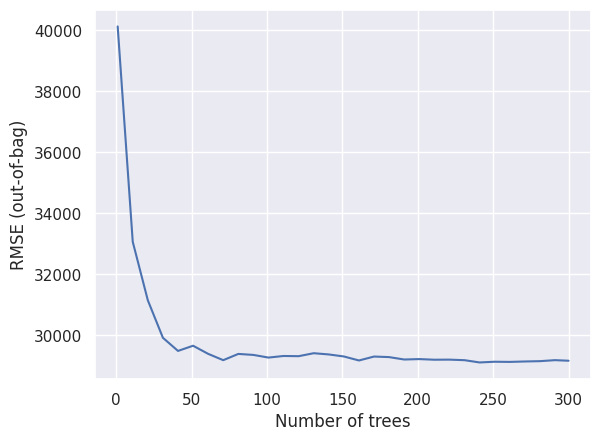

In [97]:
# Evaluate the Model
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [98]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1033, accuracy=None, loss=None, rmse=29162.339926796147, ndcg=None, aucs=None, auuc=None, qini=None)

In [99]:
evaluation = rf.evaluate(x = valid_ds,return_dict = True)

1/1 [==============================] - 7s 7s/step - loss: 0.0000e+00 - mse: 904830208.0000


In [100]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #62), 102.0),
 ("GarageCars" (1; #32), 48.0),
 ("Neighborhood" (4; #59), 47.0),
 ("ExterQual" (4; #22), 44.0),
 ("GrLivArea" (1; #38), 21.0),
 ("GarageArea" (1; #31), 9.0),
 ("KitchenQual" (4; #44), 9.0),
 ("BsmtQual" (4; #14), 8.0),
 ("TotalBsmtSF" (1; #73), 5.0),
 ("YearBuilt" (1; #75), 4.0),
 ("1stFlrSF" (1; #0), 3.0)]

    The larger the importance score for `NUM_AS_ROOT`, the more impact it has on the outcome of the model.

    By default, the list is sorted from the most important to the least. From the output you can infer that the feature at the top of the list is used as the root node in most number of trees in the random forest than any other feature.

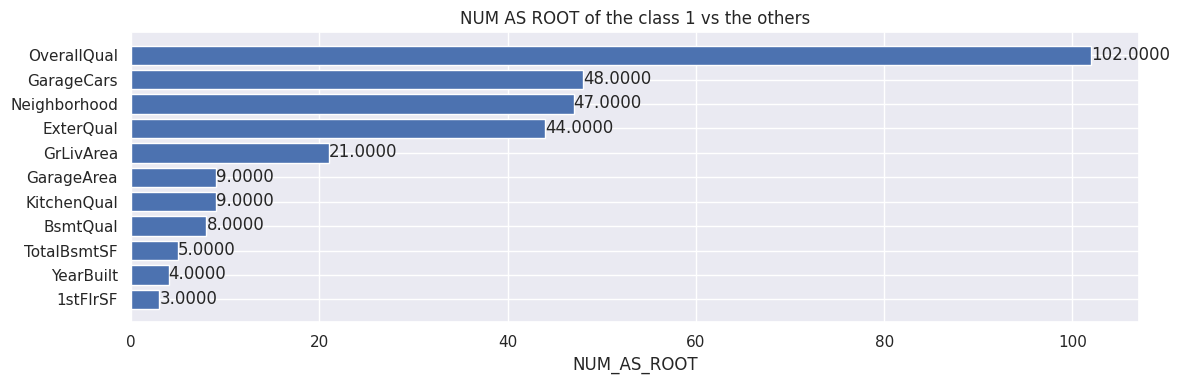

In [101]:
# Plot the variable importances from the inspector
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

#### **The best model is the Tensorflow Decision Forest (tfdf)**

### Submission

In [102]:
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids, 'SalePrice': preds.squeeze()})

output.head()

2/2 [==============================] - 1s 21ms/step


Id      SalePrice
0  1461  129687.093750
1  1462  148258.250000
2  1463  184659.750000
3  1464  186647.171875
4  1465  192888.250000

In [103]:
sample_submission_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
sample_submission_df['SalePrice'] = rf.predict(test_ds)
sample_submission_df.to_csv('/kaggle/working/submission.csv', index = False)

2/2 [==============================] - 0s 26ms/step
